# Analyzing the Differences Between Models

This notebook serves to answer the question that underlies the design of An's Tonkin Gulf Model.

The question is: What role do winds and precipitation play in an enclosed area like the Tonkin Gulf, where oceanic waves aren't as prevalant?

First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import moviepy.video.io.ImageSequenceClip
import cmocean.cm as cm
from datetime import datetime, timedelta

Next, define the location of the project directory for the model:

In [2]:
# define the project directory
project_dir = 'C:\\Users\\azure\\Documents\\CS185C\\project'

Additionally define the location of the data files:

In [3]:
run_dir = 'C:\\Users\\azure\\Documents\\CS185C\\project\\run\\diags'
zero_dir = 'C:\\Users\\azure\\Documents\\CS185C\\project\\run\\diags_zero'

Then, re-create the model grid

In [4]:
delX = 1/40
delY = 1/40
xgOrigin = 105.5
ygOrigin = 18.5
nrows = 140
ncols = 180


# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+ncols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+nrows*delY, delY)
XC, YC = np.meshgrid(xc, yc)

To assess the differences between the control model and the model ran without wind, I will create movies that showcase the difference between the two models, allowing viewers to understand at a glance the difference. First, define the plot directory:

In [5]:
plot_dir = 'C:\\Users\\azure\\Documents\\CS185C\\project\\plots'

In [6]:
plot_dict = {
    'ETAN':    [-0.05,   0.05,   cm.balance, 'm'],
    'THETA':   [-2, 2,   cm.balance, '°C'],
    'SALT':    [-0.10, 0.10 ,   cm.balance,  'PSU'],
    'MXLDEPTH':[ -5, 5,   cm.balance,    'm'],
    'UVEL':    [-1,   1,   cm.balance, 'm/s'],
    'VVEL':    [-1,   1,   cm.balance, 'm/s'],
}

# provide file names for diags
dir_meta = {
    'EtaN_day_snap':      {'var':'ETAN',      'num_slices':1, 'slice_idx':0},
    'EtaN_mon_mean':      {'var':'ETAN',      'num_slices':1, 'slice_idx':0},
    'vel_3D_mon_snap':    {'var':'VEL',       'num_slices':2, 'slice_idx':None},
    'TS_3D_mon_mean':     {'var':'TS',        'num_slices':2, 'slice_idx':None},
    'TS_surf_daily_mean': {'var':'TS',        'num_slices':2, 'slice_idx':None},
    'MXLDEPTH_day_snap':  {'var':'MXLDEPTH',  'num_slices':1, 'slice_idx':0},
    'MXLDEPTH_mon_mean':  {'var':'MXLDEPTH',  'num_slices':1, 'slice_idx':0},
}

In [7]:
def plot_diff_panel(run_directory,plot_dir, file_name ,zero_directory):

    subdir = os.path.basename(run_directory)
    meta   = dir_meta[subdir]
    nslice = meta['num_slices']
    var    = meta['var']

    def read_grid(directory):
        raw = np.fromfile(os.path.join(directory, file_name), dtype='>f4')
        ntot = raw.size
        base = nslice * nrows * ncols
        if ntot == base:
            return raw.reshape((nslice, nrows, ncols))
        else:
            assert ntot % base == 0, f"Can't reshape {ntot}"
            nextra = ntot // base
            return raw.reshape((nslice, nextra, nrows, ncols))

    # load both
    grid_run  = read_grid(run_directory)
    grid_zero = read_grid(zero_directory)

    # compute the difference
    grid_diff = grid_run - grid_zero

    # timestep for the time-bar
    timestep_number = int(file_name.split('.')[-2])
    max_timestep_number = int(366*24*60*60/30)

    # make figure & single‐column gridspec
    fig = plt.figure(figsize=(7, 8))
    gs  = GridSpec(11, 10, left=0.1, right=0.98, bottom=0.06, top=0.95, hspace=0.05)

    # collapse a 4-D to 3-D for single‐slice vars & TS
    if var != 'TS_3D' and grid_diff.ndim == 4:
        lvl        = meta.get('slice_idx', 0) or 0
        grid_diff  = grid_diff[:, lvl, :, :]  # now (nslice, nrows, ncols)

   # --- plot the difference panels ---
    if var == 'TS':
        # Surface Temperature & Salinity diffs
        # — Temperature —
        ax1 = fig.add_subplot(gs[:4, :])
        vmin, vmax, cmap, units = plot_dict['THETA']
        C1 = ax1.pcolormesh(
            XC[:, :-1], YC[:, :-1],
            grid_diff[0, :, :-1],
            vmin=vmin, vmax=vmax, cmap=cmap
        )
        plt.colorbar(C1, ax=ax1, label=f'ΔTemperature ({units})')
        ax1.set_title('ΔSurface Temperature')
        ax1.set_ylabel('Latitude')
        ax1.set_xlabel('Longitude')
    
        # — Salinity —
        ax2 = fig.add_subplot(gs[5:9, :])
        vmin, vmax, cmap, units = plot_dict['SALT']
        C2 = ax2.pcolormesh(
            XC[:, :-1], YC[:, :-1],
            grid_diff[1, :, :-1],
            vmin=vmin, vmax=vmax, cmap=cmap
        )
        plt.colorbar(C2, ax=ax2, label=f'ΔSalinity ({units})')
        ax2.set_title('ΔSurface Salinity')
        ax2.set_ylabel('Latitude')
        ax2.set_xlabel('Longitude')
    
        last_ax = ax2
    
    elif var == 'TS_3D':
        # 3-D TS: pick the requested level
        lvl = meta.get('slice_idx', 0) or 0
    
        # — Temperature at level —
        ax1 = fig.add_subplot(gs[:4, :])
        vmin, vmax, cmap, units = plot_dict['THETA']
        C1 = ax1.pcolormesh(
            XC[:, :-1], YC[:, :-1],
            grid_diff[0, lvl, :, :-1],
            vmin=vmin, vmax=vmax, cmap=cmap
        )
        plt.colorbar(C1, ax=ax1, label=f'ΔTemperature ({units})')
        ax1.set_title(f'ΔTemperature (level {lvl})')
        ax1.set_ylabel('Latitude')
        ax1.set_xlabel('Longitude')
    
        # — Salinity at level —
        ax2 = fig.add_subplot(gs[5:9, :])
        vmin, vmax, cmap, units = plot_dict['SALT']
        C2 = ax2.pcolormesh(
            XC[:, :-1], YC[:, :-1],
            grid_diff[1, lvl, :, :-1],
            vmin=vmin, vmax=vmax, cmap=cmap
        )
        plt.colorbar(C2, ax=ax2, label=f'ΔSalinity ({units})')
        ax2.set_title(f'ΔSalinity (level {lvl})')
        ax2.set_ylabel('Latitude')
        ax2.set_xlabel('Longitude')
    
        last_ax = ax2

    elif var == 'VEL':
        u2d = grid_diff[0, :, :-1]
        v2d = grid_diff[1, :, :-1]

        ax1 = fig.add_subplot(gs[:4, :])
        vmin, vmax, cmap, units = plot_dict['UVEL']
        C1 = ax1.pcolormesh(
            XC[:, :-1], YC[:, :-1], u2d,
            vmin=vmin, vmax=vmax, cmap=cmap
        )
        plt.colorbar(C1, ax=ax1, label=f'ΔU Velocity ({units})')
        ax1.set_title('ΔU Velocity')
        ax1.set_ylabel('Latitude')

        ax = fig.add_subplot(gs[5:9, :])
        vmin, vmax, cmap, units = plot_dict['VVEL']
        C2 = ax.pcolormesh(
            XC[:, :-1], YC[:, :-1], v2d,
            vmin=vmin, vmax=vmax, cmap=cmap
        )
        plt.colorbar(C2, ax=ax, label=f'ΔV Velocity ({units})')
        ax.set_title('ΔV Velocity')
        ax.set_ylabel('Latitude')
        ax.set_xlabel('Longitude')

    else:
        ax = fig.add_subplot(gs[:-2, :])
        slice_idx = meta['slice_idx'] if meta['slice_idx'] is not None else 0
        vmin, vmax, cmap, units = plot_dict[var]
        C = ax.pcolormesh(
            XC[:, :-1], YC[:, :-1],
            grid_diff[slice_idx, :, :-1],
            vmin=vmin, vmax=vmax, cmap=cmap
        )
        plt.colorbar(C, ax=ax, label=f'Δ{var} ({units})')
        ax.set_title(f'Δ{var} - {subdir}')
        ax.set_ylabel('Latitude')
        ax.set_xlabel('Longitude')

    # add the time-bar
    ax_time = fig.add_subplot(gs[-1, :-2])
    rect    = Rectangle((0, 0), timestep_number, 1, facecolor='grey', edgecolor='k')
    ax_time.add_patch(rect)
    ax_time.set_xlim([0, max_timestep_number])
    ax_time.set_ylim([0, 1])
    ax_time.set_xticks([0, max_timestep_number])
    ax_time.set_xticklabels([2004, 2005])
    ax_time.set_yticklabels([])
    ax_time.set_xlabel('Time')

    # save out
    panels_dir = os.path.join(plot_dir, 'diff_panels', var, subdir)
    os.makedirs(panels_dir, exist_ok=True)
    outname = f"{file_name[:-5]}_diff.png"
    fig.savefig(os.path.join(panels_dir, outname), facecolor='white')
    plt.close(fig)

Use the below function to plot all variables and the differences between them.

In [8]:
def plot_all(run_dir, plot_dir, zero_dir=None):
    for sub in sorted(os.listdir(run_dir)):
        run_subpath = os.path.join(run_dir, sub)
        print(run_subpath)
        if not os.path.isdir(run_subpath):
            continue
            
        # Check if the corresponding directory exists in zero_dir
        zero_subpath = None
        if zero_dir and os.path.exists(os.path.join(zero_dir, sub)):
            zero_subpath = os.path.join(zero_dir, sub)
            
        for fname in sorted(os.listdir(run_subpath)):
            if not fname.endswith('.data'):
                continue
                
            # Make sure the file exists in both directories if we're doing a comparison
            if zero_subpath and not os.path.exists(os.path.join(zero_subpath, fname)):
                print(f"Warning: File {fname} not found in zero directory. Skipping comparison.")
                plot_diff_panel(run_subpath, plot_dir, fname)  # Plot run_dir only
            else:
                # Call plot_panel with appropriate arguments
                plot_diff_panel(run_subpath, plot_dir, fname, zero_subpath)

Stitch the panels that we create into a movie for later viewing, and to animate the differences through time.

In [9]:
def create_movies(plot_dir, fps=5):
    
    diff_dir = os.path.join(plot_dir, 'diff_panels')
    if not os.path.isdir(diff_dir):
        print(f"Error: diff_panels directory not found at {diff_dir}")
        return

    # ensure movies output directory exists
    movies_dir = os.path.join(plot_dir, 'movies')
    os.makedirs(movies_dir, exist_ok=True)

    for var_name in sorted(os.listdir(diff_dir)):
        var_path = os.path.join(diff_dir, var_name)
        if not os.path.isdir(var_path):
            continue

        for diag_name in sorted(os.listdir(var_path)):
            diag_path = os.path.join(var_path, diag_name)
            if not os.path.isdir(diag_path):
                continue

            # collect all diff PNG frames
            frames = [
                os.path.join(diag_path, f)
                for f in sorted(os.listdir(diag_path))
                if f.endswith('.png')
            ]
            create_movie(frames, plot_dir, var_name, diag_name, fps)

def create_movie(panel_list, plot_dir, var_name, diag_name, fps):

    variable_descriptive_names = {
    'ETAN':    'Sea Surface Height',
    'THETA':   'Temperature',
    'SALT':    'Salinity',
    'MXLDEPTH':'Mixed Layer Depth',
    'VEL':     'Current Velocity',
    'TS':      'Temperature & Salinity'
    }
    
    diagnostic_descriptive_names = {
    'EtaN_day_snap':      'Daily Snapshot',
    'EtaN_mon_mean':      'Monthly Mean',
    'vel_3D_mon_snap':    '3D Monthly Velocity Snapshot',
    'TS_3D_mon_mean':     '3D Monthly TS Mean',
    'TS_surf_daily_mean': 'Surface TS Daily Mean',
    'MXLDEPTH_day_snap':  'Daily MLD Snapshot',
    'MXLDEPTH_mon_mean':  'Monthly MLD Mean'
    }

    nframes = len(panel_list)
    if nframes < 2:
        print(f"Skipping {var_name}/{diag_name}: only {nframes} frame(s)")
        return

    # build human-readable title (for logging)
    var_desc  = variable_descriptive_names.get(var_name, var_name)
    diag_desc = diagnostic_descriptive_names.get(diag_name, diag_name)
    print(f"Creating difference movie for {var_desc} {diag_desc} ({nframes} frames)")

    # construct output path
    movies_dir = os.path.join(plot_dir, 'movies','Difference Movies')
    movie_name = f"{var_name}_{diag_name}_diff.mp4"
    out_path   = os.path.join(movies_dir, movie_name)

    # build and write the movie
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(panel_list, fps=fps)
    clip.write_videofile(out_path, verbose=False, logger=None)
    print(f"Saved → {out_path}")

Run the methods below to generate movies of the differences. Uncomment to use.

In [10]:
#plot_all(run_dir, plot_dir, zero_dir)
#create_movies(plot_dir, 5)

## Make a timeseries
Next we can see how the differences between the models is evolving through time. For this example, I'll choose a point in the domain near the coast as in my previous notebook:

In [11]:
row = 100
col = 100

Next, I'll define a quick function to convert my iteration numbers to date and time information.

In [12]:
def iter_number_to_date(iter_number,seconds_per_iter=30):
    total_seconds = iter_number*seconds_per_iter
    date = datetime(2004,1,15) + timedelta(seconds=total_seconds)
    return(date)

Then, I'll loop through all of the output files to generate a timeseries:

In [13]:
timestep_dates = []
theta_wind_values = []
theta_no_wind_values = []
for file_name in sorted(os.listdir(os.path.join(project_dir,'run','diags','TS_surf_daily_mean'))):
    if file_name[-4:]=='data':
        # get the timestep number
        timestep_number = int(file_name.split('.')[-2])
        timestep_dates.append(iter_number_to_date(timestep_number))

        # read in the grid with the wind
        grid_wind = np.fromfile(os.path.join(project_dir,'run','diags',
                                             'TS_surf_daily_mean',
                                             file_name), '>f4')
        grid_wind = grid_wind.reshape((2,nrows,ncols))
        
        # read in the grid without the wind
        grid_no_wind = np.fromfile(os.path.join(project_dir,'run','diags_zero',
                                             'TS_surf_daily_mean',
                                             file_name), '>f4')
        grid_no_wind = grid_no_wind.reshape((2,nrows,ncols))

        theta_wind_values.append(grid_wind[0,row,col])
        theta_no_wind_values.append(grid_no_wind[0,row,col])

Finally, I'll plot the timeseries to see the comparison:

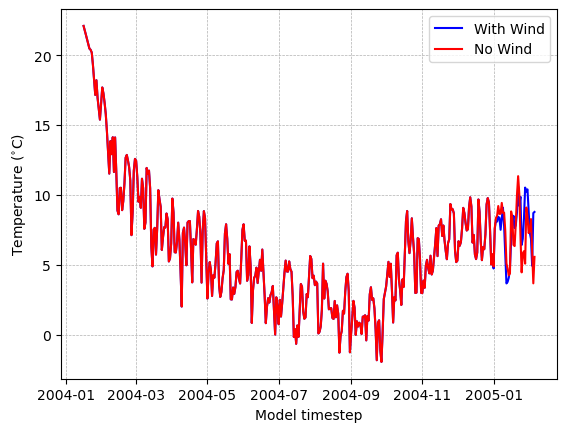

In [14]:
plt.plot(timestep_dates, theta_wind_values,'b-',label='With Wind')
plt.plot(timestep_dates, theta_no_wind_values,'r-',label='No Wind')
plt.ylabel('Temperature ($^{\circ}$C)')
plt.xlabel('Model timestep')
plt.legend()
plt.grid(linestyle='--',linewidth=0.5)
plt.show()

In this model, issues occured where the model quickly fizzled out. Since the only data that was mostly coming into the model was the boundary conditions, which are the same for both runs, this ended up in the two having nearly indistinguishable data, which resulted in most of the difference movies being 0 for the majority of the time. For some reason, once the model entered 2005, then there were some differences, which I am unable to explain.